In [ ]:
%matplotlib inline
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 33.0 MB 1.3 MB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 22.10.26 which is incompatible.


In [ ]:

import string
import gc
import re
import random
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE
import pickle
from scipy.stats import skew
import cv2
import math
from google.colab import files
from google.colab.patches import cv2_imshow
import numpy as np
from string import printable
from re import X
from IPython.core import formatters
import mediapipe
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
import xml.etree.ElementTree as ET
import mediapipe as mp
import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from io import open

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
videos = ['/content/rachel1.mp4', '/content/1-Ben-Introduction-SD.mov']
xml = ['/content/xml_extract_Rachel_2012-01-27_sc51_9.xml', 'xml_extract_1-Ben-Introduction_17.xml']


AllSigns = []
AllFrames = []
Labels = []

for video, xml in zip(videos, xml):

  capture = cv2.VideoCapture(video)
  count = 0
  frames = []
  frameNr = 0
  
  while (True):
      success, frame = capture.read()
      if success:
          frame = cv2.resize(frame, (320,240), interpolation = cv2.INTER_AREA)
          frames.append(frame)
      else:
          break
      count = count+1
  capture.release()

  print(len(frames))

  tree = ET.parse(xml)
  
  # getting the parent tag of
  # the xml document
  root = tree.getroot()
  
  # printing the root (parent) tag
  # of the xml document, along with
  # its memory location
  print(root)
  
  # printing the attributes of the
  # first tag from the parent
  print(root[0].attrib)
  
  # printing the text contained within
  # first subtag of the 5th tag from
  # the parent
  print(root[0][0][3][0][0][0][2])

  utterances= tree.findall('.//UTTERANCE')
  signs = utterances[1][3].findall('.//SIGN')
  UtteranceSigns = utterances[1][3].findall('.//SIGN')

  for sign  in tree.findall('.//SIGN'):
    # check if exists in unique_list or not
    if sign[0].text not in AllSigns:
      AllSigns.append(sign[0].text)

  label_map1 = {num:label for num, label in enumerate(AllSigns)}
  label_map2 = {label:num for num, label in enumerate(AllSigns)}

  
  for utterance in utterances:
      UtteranceSigns = utterance[3].findall('.//SIGN')
      UtteranceSignsSorted = sorted(UtteranceSigns, key=lambda x: x[13].get('START_FRAME'))
      signIDs = []
      a=0
      for sign in UtteranceSignsSorted:
        if sign.get('ID') not in signIDs:
          signIDs.append(sign.get('ID'))
          for frame_num in range(int(int(sign[13].get('START_FRAME'))/1000),int(int(sign[13].get('END_FRAME'))/1000)):
              AllFrames.append(frames[frame_num-1])
              Labels.append(label_map2[sign[0].text])

6996
<Element 'SIGNSTREAM_DAI' at 0x7fa4b1e763b0>
{}
<Element 'UTTERANCES' at 0x7fa4b1e76cb0>
4409
<Element 'SIGNSTREAM_DAI' at 0x7fa4b1e6ccb0>
{}
<Element 'UTTERANCES' at 0x7fa4b1e701d0>


In [ ]:
skinMask360 = []
for frame in AllFrames:
  img = frame.copy()
  img_bw = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # to be considered 'skin'
  hsvim = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  lower = np.array([0, 48, 80], dtype="uint8")
  upper = np.array([30, 255, 255], dtype="uint8")
  skinMask= cv2.inRange(hsvim, lower, upper)

  # blur the mask to help remove noise
  skinMask = cv2.blur(skinMask, (15, 15))

  # get threshold image
  ret, thresh = cv2.threshold(skinMask, 100, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

  distancesPerBlob = []

  # find contours in the binary image
  # Convert source image to unsigned 8 bit integer Numpy array
  # help(cv2.cvtColor)
  contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
  cntsSorted = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)

  count= 0


  for c in cntsSorted:

    if(count == 3):
      break;

    count = count+1;

    # Step #3
    out = img.copy()

    # Step #4
    ref = np.zeros_like(img_bw)
    cv2.drawContours(ref, c, -1, 255, 5)


    width = img.shape[1]
    height = img.shape[0]

    # Define total number of angles we want
    N = 360

    # Step #5
    M = cv2.moments(c)

    if(M['m00'] == 0):
      count = count-1;
      continue

    centroid_x = int(M['m10']/M['m00'])
    centroid_y = int(M['m01']/M['m00'])

    # Step #6
    for i in range(N):
      # Step #6a
      tmp = np.zeros_like(img_bw)

      # Step #6b
      theta = i*(360/N)
      theta *= np.pi/180.0

      # Step #6c
      cv2.line(tmp, (centroid_x, centroid_y),
      (int(centroid_x+np.cos(theta)*width),
      int(centroid_y-np.sin(theta)*height)), 255, 5)

      # Step #6d
      (row,col) = np.nonzero(np.logical_and(tmp, ref))

      # Step #6e
      try:
        cv2.line(out, (centroid_x, centroid_y), (col[0],row[0]), 0, 1)
        distancesPerBlob.append(math.hypot(col[0] - centroid_x, row[0] - centroid_y))
      except:
        distancesPerBlob.append(0)
      
  while len(distancesPerBlob) < 1080:
      distancesPerBlob.append(0)
  skinMask360.append(distancesPerBlob)

In [ ]:
mpHands = mp.solutions.hands
hands = mpHands.Hands(static_image_mode=True,
                      max_num_hands=2,
                      min_detection_confidence=0.5,
                      min_tracking_confidence=0.5)

In [ ]:
HandTracking = []
for frame in AllFrames:

  landmarks = []
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  results = hands.process(frame)

  count = 0
  if results.multi_hand_landmarks != None:
    for hand_landmarks in results.multi_hand_world_landmarks:
      count = count +1
      for landmark in hand_landmarks.landmark:
        landmarks.append(landmark.x)
        landmarks.append(landmark.y)
        landmarks.append(landmark.z)

    if count < 2:
      for i in range(21):
        landmarks.append(0)
        landmarks.append(0)
        landmarks.append(0)


  else:
    for i in range(2):
      for i in range(21):
        landmarks.append(0)
        landmarks.append(0)
        landmarks.append(0)
        
  HandTracking.append(landmarks)

In [ ]:
np.array(skinMask360).shape

(4956, 1080)

In [ ]:
np.array(HandTracking).shape

(4956, 126)

#Testing Feature Extraction Methods on Classification Models

#Model 1: HandTracking

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(HandTracking, Labels, test_size=0.05, random_state=42)

In [40]:
model1 = Sequential()
model1.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(126,)))
model1.add(tf.keras.layers.Dense(128, activation='relu'))
model1.add(Dense(len(label_map1)))
model1.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history1 = model1.fit(np.array(X_train1), np.array(y_train1), validation_split=0.33, epochs=100, batch_size=1,verbose=1, shuffle=True)

model1.summary()

model1.save("model1V2")
with open('trainHistory1DictV2', 'wb') as file_pi:
    pickle.dump(history1.history, file_pi)

Epoch 1/100
3154/3154 [==============================] - 9s 3ms/step - loss: 4.1900 - accuracy: 0.1642 - val_loss: 3.5707 - val_accuracy: 0.2329
Epoch 2/100
3154/3154 [==============================] - 8s 3ms/step - loss: 2.8172 - accuracy: 0.3608 - val_loss: 2.7092 - val_accuracy: 0.4151
Epoch 3/100
3154/3154 [==============================] - 8s 3ms/step - loss: 2.0138 - accuracy: 0.5181 - val_loss: 2.1835 - val_accuracy: 0.5103
Epoch 4/100
3154/3154 [==============================] - 8s 3ms/step - loss: 1.5284 - accuracy: 0.5989 - val_loss: 1.8785 - val_accuracy: 0.5792
Epoch 5/100
3154/3154 [==============================] - 8s 3ms/step - loss: 1.2129 - accuracy: 0.6658 - val_loss: 1.7387 - val_accuracy: 0.6094
Epoch 6/100
3154/3154 [==============================] - 8s 3ms/step - loss: 0.9843 - accuracy: 0.7213 - val_loss: 1.5663 - val_accuracy: 0.6654
Epoch 7/100
3154/3154 [==============================] - 8s 3ms/step - loss: 0.8161 - accuracy: 0.7587 - val_loss: 1.4884 - val_ac

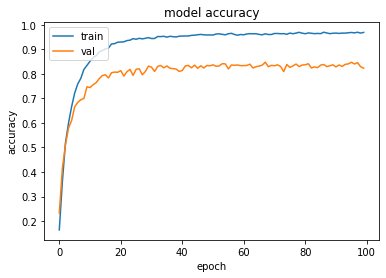

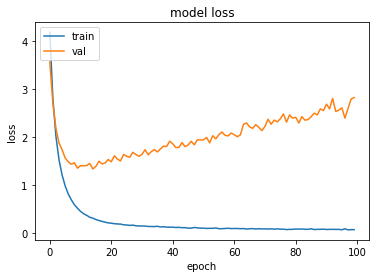

<Figure size 432x288 with 0 Axes>

In [41]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("m1V2Accuracy.png")
plt.show()
plt.clf()

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("m1V2Loss.png")
plt.show()
plt.clf()

In [47]:
score, acc = model1.evaluate(X_test1, y_test1, batch_size=1)
print('Test score:', score)
print('Test accuracy:', acc)

f = open('m1_V2_Metrics.txt','w') 
f.write("Test Score: ")
f.write(str(score))
f.write("\n\nTest Accuracy: ")
f.write(str(acc))
f.close()

248/248 [==============================] - 0s 2ms/step - loss: 2.6216 - accuracy: 0.8790
Test score: 2.6216156482696533
Test accuracy: 0.8790322542190552


#Model 2: 360 index

In [48]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(skinMask360, Labels, test_size=0.05, random_state=42)

In [49]:
model2 = Sequential()
model2.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(1080,)))
model2.add(tf.keras.layers.Dense(128, activation='relu'))
model2.add(Dense(len(label_map1)))
model2.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history2 = model2.fit(np.array(X_train2), np.array(y_train2), validation_split=0.33, epochs=100, batch_size=1,verbose=1, shuffle=True)

model2.summary()

model2.save("model2V2")
with open('trainHistory2DictV2', 'wb') as file_pi:
    pickle.dump(history2.history, file_pi)

Epoch 1/100
3154/3154 [==============================] - 9s 3ms/step - loss: 5.2323 - accuracy: 0.0523 - val_loss: 4.9448 - val_accuracy: 0.0515
Epoch 2/100
3154/3154 [==============================] - 9s 3ms/step - loss: 4.8259 - accuracy: 0.0514 - val_loss: 4.9203 - val_accuracy: 0.0515
Epoch 3/100
3154/3154 [==============================] - 8s 3ms/step - loss: 4.8171 - accuracy: 0.0498 - val_loss: 4.9187 - val_accuracy: 0.0457
Epoch 4/100
3154/3154 [==============================] - 8s 3ms/step - loss: 4.8136 - accuracy: 0.0488 - val_loss: 4.9156 - val_accuracy: 0.0515
Epoch 5/100
3154/3154 [==============================] - 8s 3ms/step - loss: 4.8117 - accuracy: 0.0501 - val_loss: 4.9313 - val_accuracy: 0.0515
Epoch 6/100
3154/3154 [==============================] - 8s 3ms/step - loss: 4.8113 - accuracy: 0.0488 - val_loss: 4.9176 - val_accuracy: 0.0515
Epoch 7/100
3154/3154 [==============================] - 8s 3ms/step - loss: 4.8097 - accuracy: 0.0510 - val_loss: 4.9180 - val_ac

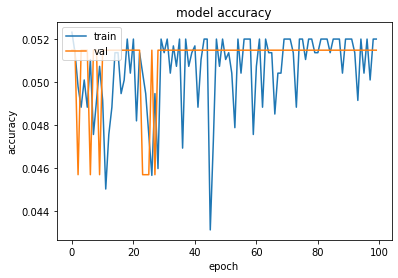

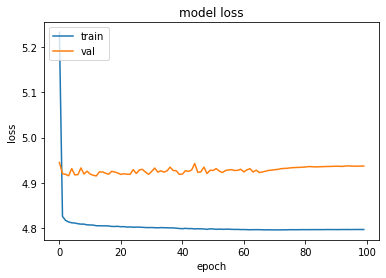

<Figure size 432x288 with 0 Axes>

In [50]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("m2V2Accuracy.png")
plt.show()
plt.clf()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("m2V2Loss.png")
plt.show()
plt.clf()

In [51]:
score, acc = model2.evaluate(X_test2, y_test2, batch_size=1)
print('Test score:', score)
print('Test accuracy:', acc)

f = open('m2_V2_Metrics.txt','w') 
f.write("Test Score: ")
f.write(str(score))
f.write("\n\nTest Accuracy: ")
f.write(str(acc))
f.close()

248/248 [==============================] - 0s 2ms/step - loss: 4.7759 - accuracy: 0.0565
Test score: 4.775938510894775
Test accuracy: 0.05645161122083664


#Model 3 

In [52]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(AllFrames, Labels, test_size=0.05, random_state=42)

In [53]:
model3 = Sequential()
model3.add(tf.keras.layers.Conv2D(3, 3, activation='relu', padding="same", input_shape=(240, 320, 3)))
model3.add(tf.keras.layers.Flatten())
model3.add(tf.keras.layers.Dense(128, activation='relu'))
model3.add(Dense(len(label_map1)))
model3.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history3 = model3.fit(np.array(X_train3), np.array(y_train3), validation_split=0.33, epochs=100, batch_size=1, verbose=1, shuffle=True)

model3.summary()

model3.save("model3V2")
with open('trainHistory3DictV2', 'wb') as file_pi:
    pickle.dump(history3.history, file_pi)

Epoch 1/100
3154/3154 [==============================] - 12s 4ms/step - loss: 91.3875 - accuracy: 0.0476 - val_loss: 5.0611 - val_accuracy: 0.0515
Epoch 2/100
3154/3154 [==============================] - 12s 4ms/step - loss: 4.9659 - accuracy: 0.0510 - val_loss: 4.9728 - val_accuracy: 0.0515
Epoch 3/100
3154/3154 [==============================] - 12s 4ms/step - loss: 4.8843 - accuracy: 0.0520 - val_loss: 4.9294 - val_accuracy: 0.0515
Epoch 4/100
3154/3154 [==============================] - 12s 4ms/step - loss: 4.8412 - accuracy: 0.0520 - val_loss: 4.9120 - val_accuracy: 0.0515
Epoch 5/100
3154/3154 [==============================] - 12s 4ms/step - loss: 4.8198 - accuracy: 0.0510 - val_loss: 4.9067 - val_accuracy: 0.0515
Epoch 6/100
3154/3154 [==============================] - 12s 4ms/step - loss: 4.8090 - accuracy: 0.0520 - val_loss: 4.9079 - val_accuracy: 0.0515
Epoch 7/100
3154/3154 [==============================] - 12s 4ms/step - loss: 4.8032 - accuracy: 0.0488 - val_loss: 4.9096 

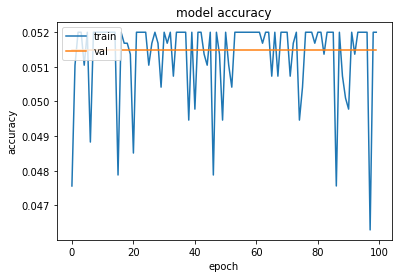

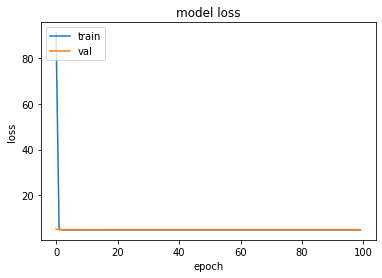

<Figure size 432x288 with 0 Axes>

In [56]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("m3V2Accuracy.png")
plt.show()
plt.clf()

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("m3V2Loss.png")
plt.show()
plt.clf()

In [60]:
score, acc = model3.evaluate(np.array(X_test3), np.array(y_test3), batch_size=1)
print('Test score:', score)
print('Test accuracy:', acc)

f = open('m3_V2_Metrics.txt','w') 
f.write("Test Score: ")
f.write(str(score))
f.write("\n\nTest Accuracy: ")
f.write(str(acc))
f.close()

248/248 [==============================] - 1s 2ms/step - loss: 4.7765 - accuracy: 0.0565
Test score: 4.776505470275879
Test accuracy: 0.05645161122083664


In [61]:
!zip -r /content/m1V2.zip /content/model1V2
!zip -r /content/m2V2.zip /content/model2V2
!zip -r /content/m3V2.zip /content/model3V2

  adding: content/model1V2/ (stored 0%)
  adding: content/model1V2/variables/ (stored 0%)
  adding: content/model1V2/variables/variables.index (deflated 64%)
  adding: content/model1V2/variables/variables.data-00000-of-00001 (deflated 12%)
  adding: content/model1V2/assets/ (stored 0%)
  adding: content/model1V2/saved_model.pb (deflated 88%)
  adding: content/model1V2/keras_metadata.pb (deflated 87%)
  adding: content/model2V2/ (stored 0%)
  adding: content/model2V2/variables/ (stored 0%)
  adding: content/model2V2/variables/variables.index (deflated 65%)
  adding: content/model2V2/variables/variables.data-00000-of-00001 (deflated 69%)
  adding: content/model2V2/assets/ (stored 0%)
  adding: content/model2V2/saved_model.pb (deflated 88%)
  adding: content/model2V2/keras_metadata.pb (deflated 87%)
  adding: content/model3V2/ (stored 0%)
  adding: content/model3V2/variables/ (stored 0%)
  adding: content/model3V2/variables/variables.index (deflated 63%)
  adding: content/model3V2/variabl

In [ ]:
files.download("/content/m1V2Accuracy.png")
files.download("/content/m2V2Accuracy.png")
files.download("/content/m3V2Accuracy.png")
files.download("/content/m1V2Loss.png")
files.download("/content/m2V2Loss.png")
files.download("/content/m3V2Loss.png")
files.download("/content/m1_V2_Metrics.txt")
files.download("/content/m2_V2_Metrics.txt")
files.download("/content/m3_V2_Metrics.txt")
files.download("/content/m1V2.zip")
files.download("/content/m2V2.zip")
files.download("/content/m3V2.zip")